=== Aperçu du dataset ===
garbage-classification-v2/
  garbage-dataset/
    battery/
      battery_1.jpg
      battery_10.jpg
      battery_100.jpg
      battery_101.jpg
      battery_102.jpg
      battery_103.jpg
      battery_104.jpg
      battery_105.jpg
      battery_106.jpg
      battery_107.jpg
      battery_108.jpg
      battery_109.jpg
      battery_11.jpg
      battery_110.jpg
      battery_111.jpg
      battery_112.jpg
      battery_113.jpg
      battery_114.jpg
      battery_115.jpg
      battery_116.jpg
      battery_117.jpg
      battery_118.jpg
      battery_119.jpg
      battery_12.jpg
      battery_120.jpg
      battery_121.jpg
      battery_122.jpg
      battery_123.jpg
      battery_124.jpg
      battery_125.jpg
      battery_126.jpg
      battery_127.jpg
      battery_128.jpg
      battery_129.jpg
      battery_13.jpg
      battery_130.jpg
      battery_131.jpg
      battery_132.jpg
      battery_133.jpg
      battery_134.jpg
      battery_135.jpg
      battery_136.j

/tmp/ipykernel_47/1087534634.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_47/1087534634.py:219: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[01/20] train_loss=1.6776 acc=0.368 | val_loss=1.6564 acc=0.451 | lr=2.00e-04
✓ Nouveau meilleur modèle sauvegardé -> resnet50_garbage_best.pth
[02/20] train_loss=1.3012 acc=0.541 | val_loss=1.6189 acc=0.463 | lr=2.00e-04
✓ Nouveau meilleur modèle sauvegardé -> resnet50_garbage_best.pth
[03/20] train_loss=1.0908 acc=0.635 | val_loss=1.4554 acc=0.581 | lr=2.00e-04
✓ Nouveau meilleur modèle sauvegardé -> resnet50_garbage_best.pth
[04/20] train_loss=0.9381 acc=0.701 | val_loss=1.3410 acc=0.614 | lr=2.00e-04
✓ Nouveau meilleur modèle sauvegardé -> resnet50_garbage_best.pth
[05/20] train_loss=0.8019 acc=0.763 | val_loss=1.4178 acc=0.575 | lr=2.00e-04
[06/20] train_loss=0.6845 acc=0.811 | val_loss=1.3290 acc=0.689 | lr=2.00e-04
✓ Nouveau meilleur modèle sauvegardé -> resnet50_garbage_best.pth
[07/20] train_loss=0.5901 acc=0.857 | val_loss=1.2365 acc=0.702 | lr=2.00e-04
✓ Nouveau meilleur modèle sauvegardé -> resnet50_garbage_best.pth
[08/20] train_loss=0.5398 acc=0.884 | val_loss=1.1057 acc=

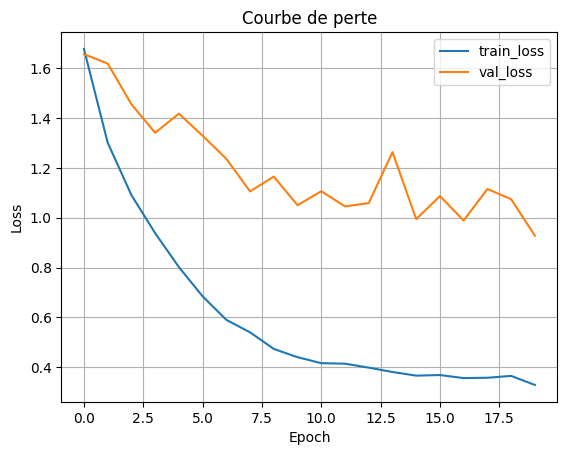

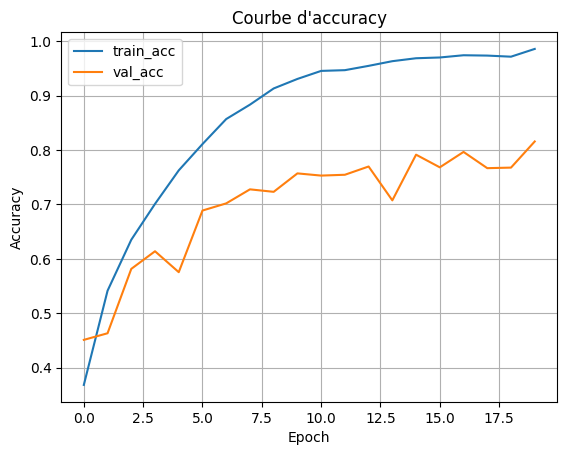

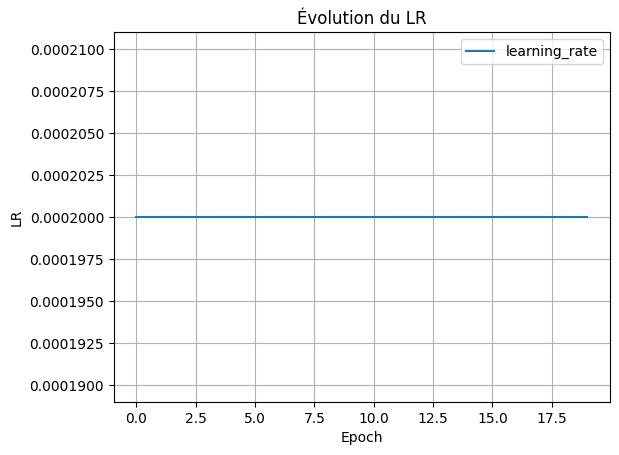


=== Pas de dossier test — Évaluation sur VAL ===


/tmp/ipykernel_47/1087534634.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Accuracy: 0.8157894736842105

Classification report:

              precision    recall  f1-score   support

     battery     0.6698    0.7634    0.7136        93
  biological     0.8246    0.8319    0.8282       113
   cardboard     0.8675    0.8471    0.8571       170
     clothes     0.9483    0.9034    0.9253       528
       glass     0.8059    0.7827    0.7942       313
       metal     0.5981    0.7111    0.6497        90
       paper     0.8012    0.7588    0.7795       170
     plastic     0.7466    0.7604    0.7534       217
       shoes     0.8054    0.7926    0.7989       188
       trash     0.6789    0.7872    0.7291        94

    accuracy                         0.8158      1976
   macro avg     0.7746    0.7939    0.7829      1976
weighted avg     0.8215    0.8158    0.8178      1976



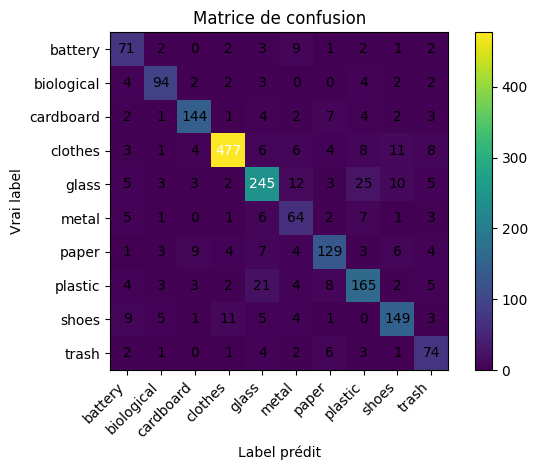

In [1]:
# ============================================================
# Garbage Classification - ResNet50 (offline, Kaggle ready)
# ============================================================

# -------- Imports
import os, glob, math, random, itertools
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# -------- Seeds (reproductibilité)
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(42)

# -------- Chemin dataset (ajoute-le via "Add data" si besoin)
DATA_DIR = "/kaggle/input/garbage-classification-v2"
assert os.path.exists(DATA_DIR), f"Dataset introuvable: {DATA_DIR}. Ajoute-le via 'Add data'."

# -------- Helper: petit tree
def tree(root, depth=2, prefix=""):
    try:
        if depth < 0 or not os.path.isdir(root): return
        print(prefix + os.path.basename(root) + "/")
        names = sorted(os.listdir(root))[:60]
        for name in names:
            path = os.path.join(root, name)
            if os.path.isdir(path):
                tree(path, depth-1, prefix+"  ")
            else:
                print(prefix+"  "+name)
    except Exception as e:
        print("tree error:", e)

print("=== Aperçu du dataset ===")
tree(DATA_DIR, 2)

# ============================================================
# 1) Datasets & Transforms
# ============================================================

# Détection folders
CANDS = [
    ("train","val","test"), ("train","valid","test"), ("train","validation","test"),
    ("Training","Validation","Test"), ("train", None, "test"),
    ("train","val", None), ("train", None, None)
]
train_dir = val_dir = test_dir = None
for a,b,c in CANDS:
    ta = os.path.join(DATA_DIR, a) if a else None
    tb = os.path.join(DATA_DIR, b) if b else None
    tc = os.path.join(DATA_DIR, c) if c else None
    cond_a = (ta and os.path.exists(ta))
    cond_b = (b is None) or (tb and os.path.exists(tb))
    cond_c = (c is None) or (tc and os.path.exists(tc))
    if cond_a and cond_b and cond_c:
        train_dir, val_dir, test_dir = ta, tb, tc
        break

# Fallback: si rien détecté, cherche un sous-dossier avec des classes
if train_dir is None:
    for name in os.listdir(DATA_DIR):
        p = os.path.join(DATA_DIR, name)
        if os.path.isdir(p):
            subdirs = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))]
            if len(subdirs) >= 2:  # supposons des classes
                train_dir = p
                break

print("\n=== Dossiers détectés ===")
print("train_dir:", train_dir, "\nval_dir:", val_dir, "\ntest_dir:", test_dir)

# Normalisation ImageNet classique (ok même sans prétrain)
norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std),
])

# Dataset train "complet" (servira aussi pour split)
full_train = datasets.ImageFolder(train_dir, transform=train_tfms)
classes = full_train.classes
num_classes = len(classes)
print("\nClasses:", classes, f"({num_classes})")

# Split val 10% si non fournie
VAL_FRAC = 0.1
if val_dir and os.path.exists(val_dir):
    val_set = datasets.ImageFolder(val_dir, transform=eval_tfms)
    train_set = full_train
else:
    n = len(full_train)
    val_n = max(1, int(VAL_FRAC*n))
    train_n = n - val_n
    train_set, val_set = random_split(
        full_train, [train_n, val_n],
        generator=torch.Generator().manual_seed(42)
    )
    # IMPORTANT: le subset val doit utiliser les tfms d'éval
    val_set.dataset.transform = eval_tfms

test_set = datasets.ImageFolder(test_dir, transform=eval_tfms) if (test_dir and os.path.exists(test_dir)) else None

# Comptage par classe (sur train_set uniquement)
def subset_labels(ds, parent):
    if hasattr(ds, 'indices'):
        return [parent.samples[i][1] for i in ds.indices]
    else:
        return [y for _,y in ds.samples]

train_labels = subset_labels(train_set, full_train)
cnt = Counter(train_labels)
print("\n=== Comptage train par classe ===")
print({classes[k]: int(v) for k,v in sorted(cnt.items())})

# Weighted sampler (pour déséquilibre)
def compute_sample_weights(ds, parent):
    labels = subset_labels(ds, parent)
    cnt = Counter(labels)
    class_w = {c: 1.0 / (cnt[c] if cnt[c] > 0 else 1.0) for c in cnt}
    # normalisation (optionnelle, juste pour échelle)
    s = sum(class_w.values()); C = len(class_w)
    class_w = {c: (w / s) * C for c, w in class_w.items()}
    weights = [class_w[y] for y in labels]
    return np.array(weights, dtype=np.float32)

use_weighted_sampler = True
BATCH_SIZE = 32
NUM_WORKERS = 2

if use_weighted_sampler:
    w = compute_sample_weights(train_set, full_train)
    sampler = WeightedRandomSampler(weights=torch.as_tensor(w), num_samples=len(w), replacement=True)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True)
else:
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=True)

val_loader  = DataLoader(val_set,  batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)
test_loader = (DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True) if test_set else None)

# ============================================================
# 2) Modèle (ResNet50 offline) + Loss/Optim/Scheduler
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice:", device)

# Aucun téléchargement : weights=None
model = models.resnet50(weights=None)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device)

# Poids de classes (autre protection contre l'imbalance) + label smoothing
counts = np.zeros(num_classes, dtype=np.float32)
for y in train_labels:
    counts[y] += 1
cls_w = torch.tensor((counts.sum() / (counts + 1e-6)), dtype=torch.float32)
cls_w = (cls_w / cls_w.mean()).to(device)

criterion = nn.CrossEntropyLoss(weight=cls_w, label_smoothing=0.05)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# Mixed precision auto si CUDA
use_amp = (device.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# ============================================================
# 3) Entraînement + Early Stopping
# ============================================================

EPOCHS = 20          # from scratch: n'hésite pas à monter (30-40) si besoin
early_patience = 4
best_val_acc = 0.0
epochs_no_improve = 0

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}

def run_epoch(loader, train_mode=True):
    model.train(mode=train_mode)
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train_mode):
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(x)
                loss = criterion(logits, y)

        if train_mode:
            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(1)
        total += y.size(0)
        correct += (pred == y).sum().item()

    return loss_sum/total, correct/total

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)
    va_loss, va_acc = run_epoch(val_loader,   train_mode=False)
    scheduler.step(va_loss)
    cur_lr = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    history["lr"].append(cur_lr)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.3f} | lr={cur_lr:.2e}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save({
            "model_state": model.state_dict(),
            "classes": classes,
            "epoch": epoch,
            "val_acc": best_val_acc,
            "norm_mean": norm_mean,
            "norm_std": norm_std,
        }, "resnet50_garbage_best.pth")
        print("✓ Nouveau meilleur modèle sauvegardé -> resnet50_garbage_best.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_patience:
            print(f"Early stopping (patience={early_patience})")
            break

print(f"\nBest val_acc: {best_val_acc:.3f}")

# ============================================================
# 4) Tracés: Loss / Accuracy / LR
# ============================================================

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Courbe de perte"); plt.grid(True); plt.legend(); plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Courbe d'accuracy"); plt.grid(True); plt.legend(); plt.show()

plt.figure()
plt.plot(history["lr"], label="learning_rate")
plt.xlabel("Epoch"); plt.ylabel("LR"); plt.title("Évolution du LR"); plt.grid(True); plt.legend(); plt.show()

# ============================================================
# 5) Évaluation: test set (sinon val) + Matrice de confusion
# ============================================================

# Recharge le meilleur modèle
ckpt = torch.load("resnet50_garbage_best.pth", map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model = model.to(device).eval()

def evaluate(loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(x)
            pred = logits.argmax(1).detach().cpu().numpy().tolist()
            y_pred += pred
            y_true += y.numpy().tolist()
    return np.array(y_true), np.array(y_pred)

if test_loader is not None:
    print("\n=== Évaluation sur TEST ===")
    y_true, y_pred = evaluate(test_loader)
else:
    print("\n=== Pas de dossier test — Évaluation sur VAL ===")
    y_true, y_pred = evaluate(val_loader)

acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
fig = plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Matrice de confusion"); plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, classes, rotation=45, ha="right"); plt.yticks(ticks, classes)
thresh = cm.max() / 2. if cm.max() > 0 else 0.5
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, str(cm[i, j]),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel("Vrai label"); plt.xlabel("Label prédit")
plt.tight_layout(); plt.show()

# ============================================================
# 6) Inférence sur une image (exemple)
# ============================================================

infer_tfms = eval_tfms
def predict_image(path):
    img = Image.open(path).convert("RGB")
    x = infer_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            prob = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    idx = int(np.argmax(prob))
    return classes[idx], float(prob[idx])

# Exemple d'utilisation (décommente et adapte si tu veux tester) :
# sample_candidates = glob.glob(os.path.join(test_dir or val_dir or train_dir, classes[0], "*"))
# if sample_candidates:
#     pred, p = predict_image(sample_candidates[0])
#     print("Pred:", pred, f"{p:.1%}", " | file:", sample_candidates[0])
